# Ripser Examples
This Jupyter Notebook explores the Ripser python library for the use of Topological Data analysis

To install Ripser follow the instructions here: [Installing Ripser](https://ripser.scikit-tda.org/en/latest/index.html)

Detailed documentation of the Ripser Library can be found here: [documentation](https://ripser.scikit-tda.org/en/latest/index.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
import os
import time
from ripser import ripser
from persim import plot_diagrams
import csv

# ipython to display plots. You may need to run 'pip install ipython'
# Using this mode will make 3d plots interactable meaning you can rotate the plots
# How ever this will also open plots in a new window.
# Uncomment this line to use the ipython backend
# %matplotlib

The following two functions have been included to easily create and visualize point clouds from spheres of any dimension

In [2]:
def generate_point_cloud_from_sphere(num_points=100, radius=1, dim=2, error=.2):
    """
    Generates a point cloud from a sphere with dimension dim

    :param num_points: Number of points in generated point cloud
    :param radius: radius of sphere that points are picked from
    :param dim: dimension of the space in which the sphere will be created. dim=2 a circle, dim=3 a sphere and so on
    :param error: this specifies uncertainly in the points. Possible Error is selected uniformly between the interval [-error, error], for each coordinate in each point
    :return: numpy array of the points in the point cloud
    """
    def apply_error(val):
        """ Helper function to add the error """
        return val + random.uniform(-1 * error, error)

    # First generate random array of size (dim, num_points) and normalize them so they fall on unit ball
    random_points = np.random.normal(size=(dim, num_points))
    random_points /= np.linalg.norm(random_points, axis=0)

    # Return the list of random points scaled by the radius and with a random error applied
    return radius * np.array([[apply_error(p) for p in row] for row in random_points]).T


def draw_point_cloud(data, e_radius=None, save_file=None, holes=None):
    """
    Draws point cloud in either 2 or 3 dimensional space

    :param data: Point cloud as numpy array
    :param e_radius: Radius of epsilon balls. Use None to not include them
    :param save_file: Save file location (without .png) to save plot, Also acts as title
    :return: figure, wont open window of figure, so you must do plt.show()
    """
    fig = plt.figure()

    if data.shape[1] == 2:
        x = data.T[0]
        y = data.T[1]

        ax = fig.add_subplot()

        ax.scatter(x, y)

        if e_radius is not None:
            theta = np.linspace(0, 2 * np.pi, 150)
            for xp, yp in zip(x, y):
                ax.plot(e_radius * np.cos(theta) + xp, e_radius * np.sin(theta) + yp, color='black')

    elif data.shape[1] == 3:
        x, y, z = data.transpose()

        ax = fig.add_subplot(projection='3d')

        ax.scatter(x, y, z)

        if e_radius is not None:
            phi, theta = np.mgrid[0:2 * np.pi:10j, 0:np.pi:10j]
            for xp, yp, zp in zip(x, y, z):
                ax.plot_surface(e_radius * np.cos(phi) * np.sin(theta) + xp, e_radius * np.sin(phi) * np.sin(theta) + yp,
                                e_radius * np.cos(theta) + zp, alpha=0.5)

    else:
        raise ValueError("Data must have dimension 2 or 3 to create plot.")

    if holes is not None:
        for hole in holes:
            for face in hole:
                if data.shape[1] == 2:
                    ax.plot([face[0][0], face[1][0]], [face[0][1], face[1][1]], color='black')
                elif data.shape[1] == 3:
                    ax.add_collection3d(Poly3DCollection(np.array(face), color='black', alpha=.5))

    if save_file is not None:
        ax.set_title(save_file)
        fig.savefig(save_file)
    return fig

## Using Ripser for TDA
First, we need to create our data.
Using the `generate_point_cloud_from_sphere` function we can create a point cloud of 200 data point from a sphere. To use spheres of higher dimension change the dim parameter. Setting dim=2 will create a circle.

Set the variable `dimension` to your desired dimension. This will be used later to create the simplex tree

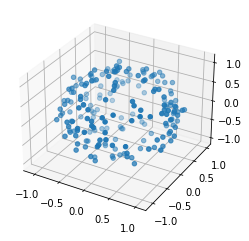

In [3]:
dimension = 3

point_cloud = generate_point_cloud_from_sphere(num_points=200, radius=1, dim=dimension, error=.1)
fig = draw_point_cloud(point_cloud)
plt.show()

Alternatively, you can load a point cloud from a CSV or txt file in the following way.

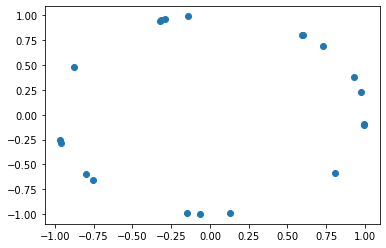

In [4]:
# point_cloud = np.genfromtxt(r"location\of\file.csv", delimiter=',')
dimension = 2
point_cloud = np.genfromtxt(".\\..\\..\\scripts\\ph_algo\\point_cloud_test.csv", delimiter=',')
fig = draw_point_cloud(point_cloud)
plt.show()

  ## You may need to do some addigtional processing to ensure the data is correctly formatted

## Vietoris-Rips Complex
Ripser allows us to create a filtered Vietoris Rips complex and run persistence cohomology algorithms through the use of the `ripser()` function.


This function allows us to specify the field to work over as well as the max dimension of homology to compute. Notice that this means when `maxdim=2` then the algorithm will compute $H_0$, $H_1$ and $H_2$. The documentation for this function can be found [here](https://ripser.scikit-tda.org/en/latest/reference/stubs/ripser.ripser.html#ripser.ripser).


In [4]:
start_time = time.time()

result = ripser(point_cloud, coeff=11, maxdim=dimension-1)

end_time = time.time()
print(f"Persistence Cohomology computed in {end_time - start_time} seconds")

Persistence Cohomology computed in 1.2573485374450684 seconds


## Interpreting the Data, and Persistence diagrams

### Persistence Diagrams
Persistence diagrams represent the homology classes. Each point represents a feature, and in general, the further a point is from the identity line the longer the life span is, and therefore the more likely it is a feature in the underlying topology.

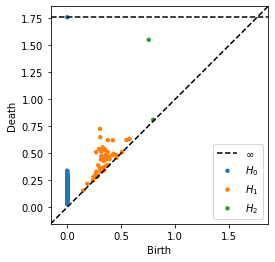

In [5]:
plot_diagrams(result['dgms'], show=True)

Based on the above plot and specifically the points for dimension 2, we know that $\text{dim}(H_2)=1$ for a large portion of the filtration. This indicates that there is very likely a large void in the point cloud, which is exactly what we expect to see as the point cloud was a sphere. 

## Sparse Vietros-Rips Complex
Ripser supports different variations of the Rips complex, one option the sparse Rips complex, which is an approximation of the VR complex. In the worse case, the VR complex will have exponentially many, $2^{O(n)}$, simplices for a point cloud with $n$ points. The sparse VR complex can reduce the number of simplices to be linear $O(n)$ with respect to the number of points in the point cloud. However, it is important to note that this approximation is not guaranteed to preserve the Homology.

Ripser implements this with the added parameter `n_perm` in the `ripser` function. This parameter specifies the number of points to sample from the original point cloud to create an approximation. 


Persistence Homology computed in 0.15210580825805664 seconds


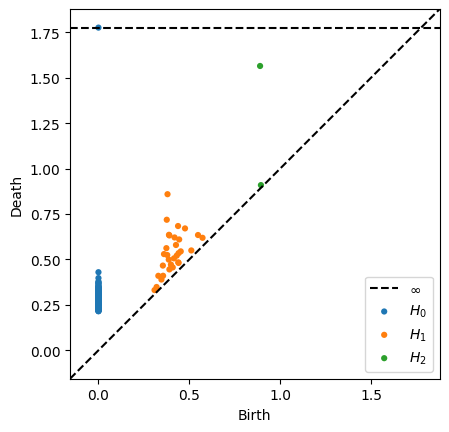

[[-6.08243583e-01  8.82227652e-01 -1.11719797e-01]
 [ 6.13238303e-01 -8.99127479e-01 -2.68547315e-02]
 [-8.93384971e-02 -6.61197087e-02  1.06058396e+00]
 [ 9.33969512e-01  5.85000273e-01  3.96441840e-02]
 [-8.84402531e-01 -6.80579624e-01 -6.83361401e-02]
 [ 5.51058780e-02 -1.28338015e-01 -1.02175158e+00]
 [-9.05483559e-01  1.31012914e-01  4.66186778e-01]
 [ 1.74761509e-01  8.70711758e-01  5.07153349e-01]
 [-1.52489085e-01 -8.29309313e-01  5.64273598e-01]
 [-8.93778186e-01  1.08401892e-01 -5.24200788e-01]
 [ 6.55217677e-02  7.33828202e-01 -7.80046642e-01]
 [ 9.39326485e-01 -2.58986923e-01  5.00832449e-01]
 [-9.00820322e-02 -8.60594389e-01 -5.97158736e-01]
 [ 8.72740056e-01 -6.81816554e-02 -5.00918702e-01]
 [ 3.47914223e-01  9.48072679e-01 -1.54989517e-01]
 [-4.61859418e-01  7.37758120e-01  7.14560245e-01]
 [-4.84393655e-01 -3.69694523e-01 -6.91221036e-01]
 [ 4.71621538e-01 -5.98966418e-01 -5.58006153e-01]
 [-3.34084061e-01 -8.86813906e-01  3.34397737e-03]
 [-4.86428841e-01 -3.79007642e-

In [6]:
# We will rerun the ripser fucntion expect with half the number of points
start_time = time.time()

res = ripser(point_cloud, n_perm=100, coeff=11, maxdim=dimension-1)

end_time = time.time()
print(f"Persistence Homology computed in {end_time - start_time} seconds")


# plot
plot_diagrams(res['dgms'], show=True)


# We can retrieve the points in the approximation with
idx_perm = res['idx_perm']
# print(point_cloud[idx_perm])


This gave us a rather substantial speed up while keeping the relevant homology. Decreasing the value of `n_perm` can give us an even faster approximation algorithm. However, decreasing the value too much can result in the features not being detected. For example when `n_perm=10` we were unable to find the 2-hole or void with any substantial amount of certainty. However, this is a rather low number of points to use

Persistence Homology computed in 0.005017757415771484 seconds


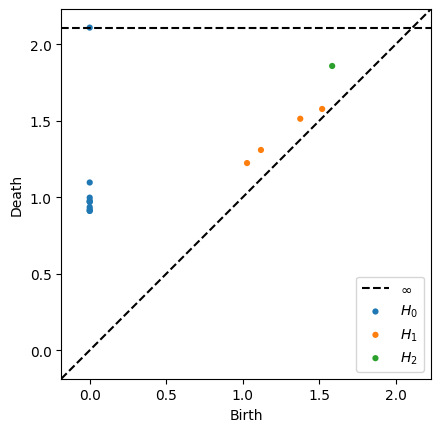

In [7]:
start_time = time.time()

res = ripser(point_cloud, n_perm=10, coeff=11, maxdim=dimension-1)

end_time = time.time()
print(f"Persistence Homology computed in {end_time - start_time} seconds")


# plot
plot_diagrams(res['dgms'], show=True)

## Representative Cocycles
Unfortunately Ripser is only able to compute representative cocycles and not cycles

By passing `do_cocycles=True` ripser will compute the cocycles. 

In the example below I isolated the largest and second-largest cocycle representative for the $H^1$ cohomology class

c:\users\jorqu\anaconda3\envs\scripts\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\jorqu\anaconda3\envs\scripts\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


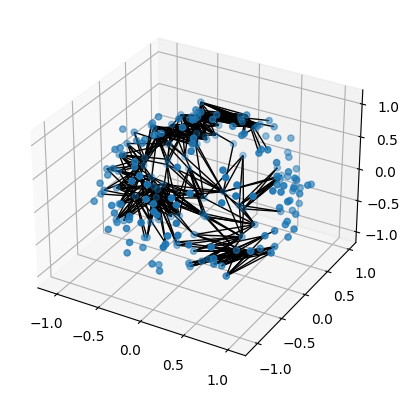

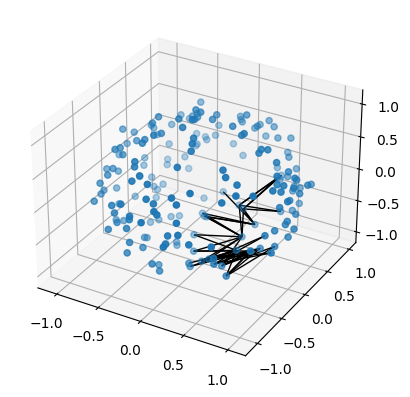

In [18]:
res = ripser(points, coeff=11, maxdim=1, do_cocycles=True)

hole = sorted(res['cocycles'][1], key=lambda x: len(x), reverse=True)[0]

holes = [[[points[point] for point in face[:-1]] for face in hole]]
draw_point_cloud(points, holes=holes)
plt.show()

hole2 = sorted(res['cocycles'][1], key=lambda x: len(x), reverse=True)[1]

holes2 = [[[points[point] for point in face[:-1]] for face in hole2]]
draw_point_cloud(points, holes=holes2)
plt.show()

